In [1]:
!pip install cryptography pillow opencv-python matplotlib

In [2]:
from cryptography.hazmat.primitives.asymmetric import x25519
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.ciphers.aead import AESGCM

from PIL import Image
import numpy as np
import os, matplotlib.pyplot as plt

In [3]:
from google.colab import files
uploaded = files.upload()       # choose a local PNG (e.g., "cover.png")

Saving cover.png to cover.png


In [4]:
# Generate key pair for sender and receiver
sender_private = x25519.X25519PrivateKey.generate()
sender_public  = sender_private.public_key()

receiver_private = x25519.X25519PrivateKey.generate()
receiver_public  = receiver_private.public_key()

In [5]:
# Derive shared secret (sender uses receiver’s public key)
shared_key = sender_private.exchange(receiver_public)

# Derive symmetric key
kdf = HKDF(algorithm=hashes.SHA256(), length=32, salt=None, info=b'stego-demo')
sym_key = kdf.derive(shared_key)

# Encrypt
aes = AESGCM(sym_key)
nonce = os.urandom(12)
plaintext = b"Hello from ECC-Stego!"
ciphertext = aes.encrypt(nonce, plaintext, None)

len(ciphertext), ciphertext[:20]

(37, b'a.\xc0\xbba\xb7\x82\x97<_r\xcd3\x97\xf1\xae\xa4\xb4\x0e\xb3')

In [6]:
def embed_lsb(cover_path, secret_bytes, out_path):
    img = Image.open(cover_path).convert('RGB')
    arr = np.array(img)
    flat = arr.flatten()

    bits = ''.join(f'{b:08b}' for b in secret_bytes)
    if len(bits) > len(flat):
        raise ValueError("Secret too big for this image")

    for i, bit in enumerate(bits):
        flat[i] = (flat[i] & ~1) | int(bit)

    stego = flat.reshape(arr.shape)
    Image.fromarray(stego.astype(np.uint8)).save(out_path)

def extract_lsb(stego_path, length):
    img = Image.open(stego_path).convert('RGB')
    flat = np.array(img).flatten()

    bits = ''.join(str(flat[i] & 1) for i in range(length*8))
    return bytes(int(bits[i:i+8], 2) for i in range(0, len(bits), 8))

In [7]:
cover_image = "cover.png"
stego_image = "stego.png"

def embed_lsb(cover_path, secret_bytes, out_path):
    from PIL import Image
    import numpy as np

    # Open and flatten the cover image
    img = Image.open(cover_path).convert('RGB')
    arr = np.array(img)
    flat = arr.flatten()

    # Convert secret bytes to bit string
    bits = ''.join(f'{b:08b}' for b in secret_bytes)
    needed = len(bits)
    capacity = len(flat)

    # Check capacity
    if needed > capacity:
        raise ValueError(
            f"Message too large! Need {needed} bits but image can store only {capacity} bits."
        )

    # Convert flat array to int32 to avoid overflow issues
    flat = flat.astype(np.int32)

    # Embed bits
    for i, bit in enumerate(bits):
        flat[i] = (flat[i] & ~1) | int(bit)

    # Convert back to uint8 and reshape
    stego = flat.astype(np.uint8).reshape(arr.shape)
    Image.fromarray(stego).save(out_path)

    print(f"✅ Embedded {len(secret_bytes)} bytes into {out_path}")

# Try embedding
embed_lsb(cover_image, nonce + ciphertext, stego_image)


✅ Embedded 49 bytes into stego.png


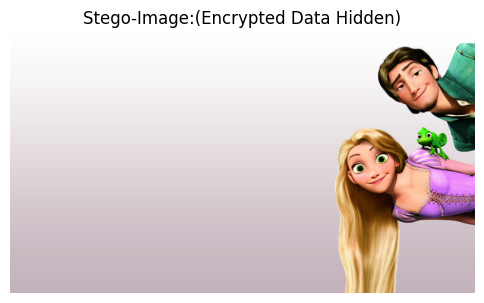

In [8]:
# Show the resulting stego-image (the "encrypted" image)
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Define the stego_image variable
stego_image = "stego.png"

# Load the stego-image
stego_img = Image.open(stego_image)

plt.figure(figsize=(6, 6))
plt.imshow(stego_img)
plt.title(f"Stego-Image:(Encrypted Data Hidden)")
plt.axis('off') # Hide axes for a cleaner view
plt.show()

In [9]:
from PIL import Image
import numpy as np

img = Image.open(cover_image).convert('RGB')
capacity = img.width * img.height * 3   # 3 channels → 1 bit per channel
print(f"Image capacity ≈ {capacity} bits ≈ {capacity//8} bytes")

print(f"Secret size ≈ {len(nonce + ciphertext)} bytes")

Image capacity ≈ 6220800 bits ≈ 777600 bytes
Secret size ≈ 49 bytes


In [10]:
def extract_lsb(stego_path, length):
    from PIL import Image
    import numpy as np

    img = Image.open(stego_path).convert('RGB')
    flat = np.array(img).flatten()

    bits = ''.join(str(flat[i] & 1) for i in range(length*8))
    return bytes(int(bits[i:i+8], 2) for i in range(0, len(bits), 8))

# Extract
extracted = extract_lsb(stego_image, len(nonce + ciphertext))

# Separate nonce and ciphertext
nonce_ex = extracted[:12]
ct_ex = extracted[12:]

# Receiver side key
shared_key_recv = receiver_private.exchange(sender_public)
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.ciphers.aead import AESGCM

kdf = HKDF(algorithm=hashes.SHA256(), length=32, salt=None, info=b'stego-demo')
sym_key_recv = kdf.derive(shared_key_recv)

aes2 = AESGCM(sym_key_recv)
recovered = aes2.decrypt(nonce_ex, ct_ex, None)

print("✅ Recovered message:", recovered.decode())

✅ Recovered message: Hello from ECC-Stego!


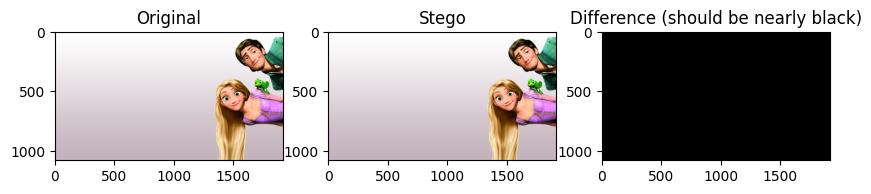

Non-zero pixel differences: 198


In [11]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

orig = np.array(Image.open(cover_image))
stego = np.array(Image.open(stego_image))

diff = np.abs(orig.astype(int) - stego.astype(int))

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(orig); plt.title("Original")
plt.subplot(1,3,2); plt.imshow(stego); plt.title("Stego")
plt.subplot(1,3,3); plt.imshow(diff); plt.title("Difference (should be nearly black)")
plt.show()

print("Non-zero pixel differences:", np.count_nonzero(diff))